## Notebook for Figure 5 and related content: Gene expression changes in beta-cells from T2D donors and obesity
### Author: J. Camunas-Soler
### Last Updated: Feb. 2020

In [8]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
%matplotlib inline
from singlet.dataset import Dataset
from singlet import SampleSheet, CountsTable
import matplotlib.patches as mpatches

In [9]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


In [10]:
%run ./../functions/helper_functions.py

In [11]:
root_folder = './../data/'
analysis_folder = './../analysis/'
fig_folder = './../figures/fig5_suppfig5/'

#### Load Data and definitions

In [12]:
dict_phenotype_norm = {'CellSize_pF': 'Cell size',
                   'NormalizedTotalCapacitance_fF/pF': 'Total Exocitosis',
                   'NormalizedFirstDepolarizationCapacitance_fF/pF': 'Early exocytosis',
                   'NormalizedLateDepolarizationCapacitance': 'Late exocytosis',
                 'CalciumIntegralNormalizedtoCellSize_pC/pF': 'Ca2+ entry',
                   'CapacitanceNormalizedtoCalcium_fF/pC': 'Exocytosis norm Ca2+',
                   'NormalizedEarlyPeakCalciumCurrentAmplitude_pA/pF': 'Early Ca2+ current',
                 'NormalizedLateCalciumCurrentAmplitude_pA/pF': 'Late Ca2+ current',
                   'NormalizedLateCalciumChannelConductance_pS/pF' : 'Late Ca2+ Conductance',
                   'ReversalPotentialbyramp_mV': 'Reversal potential',
                   'NormalizedPeakSodiumCurrentAmplitude_pA/pF': 'Peak Na+ current',
                  'NormalizedSodiumChannelConductance_pS/pF': 'Na+ conductance'}

phenotype_norm = ['Cell size', 'Total Exocitosis','Early exocytosis','Late exocytosis',
                          'Ca2+ entry','Exocytosis norm Ca2+', 'Early Ca2+ current','Late Ca2+ current',
                          'Late Ca2+ Conductance','Reversal potential','Peak Na+ current','Na+ conductance']

In [13]:
#Load and reformat patch-seq dataset
filename =  root_folder + 'patchclamp_wcryo_human.counts.tab'
metadata = root_folder + 'patchclamp_wcryo_human.metadata.tab'

test = pd.read_csv(filename,sep='\t')
annotation = pd.read_csv(metadata,'\t')
annotation = annotation.drop(['cell_type'],axis=1)

annotation['DiabetesStatus'].replace({'heathy': 'healthy'}, inplace=True)
annotation['DiabetesStatus'].replace({'elevated HbA1c': 'T2D'}, inplace=True)
#add cell type information already computed
ct_all = pd.read_csv(analysis_folder + 'cell_typing_merged.csv', sep='\t', index_col=0, names=['cell_type'])
ct_FACS = pd.read_csv(analysis_folder +'cell_typing_FACS_endocrine.csv', sep='\t', index_col=0, names=['cell_type'])
ct_all = pd.concat([ct_all,ct_FACS])
annotation = annotation.join(ct_all['cell_type'], on='name')

annotation.rename(columns=dict_phenotype_norm, inplace=True)
#remove commas from data ephys
annotation[phenotype_norm] = annotation[phenotype_norm].apply(lambda x: pd.to_numeric(x.astype(str)
                                                   .str.replace(',',''), errors='coerce'))
annotation[phenotype_norm] = annotation[phenotype_norm].astype(float)

#remove genes not seen in 5 cells or having 10 counts total
test= filter_genes_pp(test, min_cells=5, min_counts=10)
#create dataset
ds = Dataset(counts_table=CountsTable(test),samplesheet=SampleSheet(annotation))
#remove nans in glucse
ds.samplesheet = ds.samplesheet[~ds.samplesheet[['Glucose_mM']].isnull().values]
#save unnormalized table
ds_pclamp_raw = ds.copy()
# Get data and normalize gene expression to combine cell size plot and marker genes
ds_norm = ds.copy()
ds_norm.counts = ds_norm.counts.normalize()
ds_norm.counts.pseudocount = 1
ds_norm.counts = ds_norm.counts.log(base=2)
ds_norm.counts.pseudocount = 1
ds_norm_pclamp = ds_norm.copy()

filter_condition = {'Cryopreserved': ['Yes']}
ds_t1d = filter_samplesheet(ds_norm, filter_dict= filter_condition)

filter_condition = {'Cryopreserved': ['No']}
ds_pclamp = filter_samplesheet(ds_norm, filter_dict= filter_condition)

#### Fig 5a and Supp Fig 5

In [14]:
filter_condition = {'cell_type': ['beta'],
                    'Cryopreserved':['No'],
                   'Patched': ['Yes'],
                    'DiabetesStatus': ['healthy','T2D'],
                    'TimefromDispersion_days': [1,2,3,4],
                     'Glucose_mM': [5,10],
                   'preincubation': ['Yes','No']}

#this uexports normalized counts for Mann-Whitney
ts = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)


groupby_col = 'DiabetesStatus'
groups = ['healthy','T2D']
thres=2
pars = ['Total Exocitosis',
 'Late exocytosis',
 'Early exocytosis',
 'Exocytosis norm Ca2+',
 'Ca2+ entry',
 'Early Ca2+ current',
 'Late Ca2+ current',
 'Late Ca2+ Conductance',
 'Peak Na+ current',
 'Na+ conductance']

cols = pars + [groupby_col]

qlow=0.03
qhigh=0.97

x = filter_quantile_values(ts.samplesheet, columns=pars, qlow=qlow,qhigh=qhigh, include_quantiles=False)

for par in pars:
    if x[par].mean() < 0:
        x[par] = -1*(x[par])
    #clip value of electrophysiology to zero, no negative values
    x[par] = x[par].clip(lower=0)

#mask zero values
x[pars] = x[pars].mask(x[pars]<=0)
#prepare melted dataset
t = x[cols]

/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)
/Users/joan/anaconda/envs/scanpy/lib/python3.

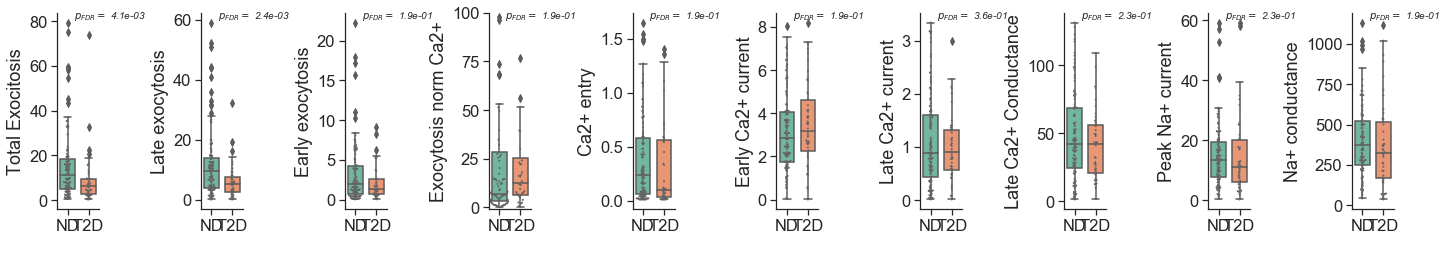

In [15]:
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

fig,axs= plt.subplots(nrows=1,ncols=10,figsize=(20,4))
axs = axs.flatten()

pars = ['Total Exocitosis',
 'Late exocytosis',
 'Early exocytosis',
 'Exocytosis norm Ca2+',
 'Ca2+ entry',
 'Early Ca2+ current',
 'Late Ca2+ current',
 'Late Ca2+ Conductance',
 'Peak Na+ current',
 'Na+ conductance']


pvals = df_get_mu_pvals(t, pars=pars, column_class='DiabetesStatus',categories=['healthy','T2D'])
new_pal= ['#636363','#636363']
for i,par in enumerate(pars):
    #sns.violinplot(y=par, data=t,x='DiabetesStatus',ax=axs[i],palette='Pastel2', inner='quartile',cut=0)
    sns.boxplot(y=par, data=t,x='DiabetesStatus',ax=axs[i],palette='Set2', width=0.7)
    sns.swarmplot(y=par, data=t,x='DiabetesStatus',ax=axs[i], palette=new_pal,size=2)
    axs[i].text(0.4,0.97, r'$p_{{FDR}}=$ {:.1e}'.format(pvals.loc[par,'FDR']), style='italic',fontsize=10, transform = axs[i].transAxes)
    axs[i].set_xlabel(' ')
    axs[i].set_xticklabels(['ND','T2D'])
    if par =='Exocytosis norm Ca2+':
        axs[i].set_ylim(-1,100)

sns.despine()
fig.tight_layout()
fig.savefig(fig_folder+'suppfig5a.pdf')

In [16]:
pvals = df_get_mu_pvals(t, pars=pars, column_class='DiabetesStatus',categories=['healthy','T2D'])
pvals

,pval,FDR
Total Exocitosis,0.000830,0.004149
Late exocytosis,0.000244,0.002437
Early exocytosis,0.136088,0.194412
Exocytosis norm Ca2+,0.103006,0.194412
Ca2+ entry,0.104171,0.194412
Early Ca2+ current,0.121312,0.194412
Late Ca2+ current,0.358859,0.358859
Late Ca2+ Conductance,0.210196,0.233551
Peak Na+ current,0.209607,0.233551
Na+ conductance,0.132146,0.194412


/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/seaborn/categorical.py:1308: RuntimeWarning: invalid value encountered in absolute
  offsets = np.abs(candidates[:, 0] - midline)


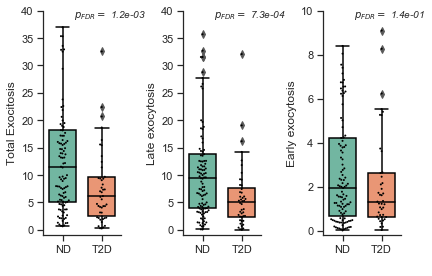

In [17]:
sns.set(font_scale=1)
sns.set_style('whitegrid')
sns.set()

sns.set_style("white", {"axes.edgecolor": '0','axes.labelcolor': '0',
                        'text.color': '0','xtick.color': '0','ytick.color': '0'})
sns.set_style("ticks",{"xtick.major.size": 8, "ytick.major.size": 8})
fig,axs= plt.subplots(nrows=1,ncols=3,figsize=(6,4))
axs = axs.flatten()

pars = ['Total Exocitosis',
 'Late exocytosis',
 'Early exocytosis']

pvals = df_get_mu_pvals(t, pars=pars, column_class='DiabetesStatus',categories=['healthy','T2D'])
new_pal= ['#636363','#636363']
for i,par in enumerate(pars):
    #sns.violinplot(y=par, data=t,x='DiabetesStatus',ax=axs[i],palette='Pastel2', inner='quartile',cut=0)
    sns.boxplot(y=par, data=t,x='DiabetesStatus',ax=axs[i],palette='Set2', width=0.7)
    sns.swarmplot(y=par, data=t,x='DiabetesStatus',ax=axs[i],size=2,
                  color="0", edgecolor='0')
    axs[i].text(0.4,0.97, r'$p_{{FDR}}=$ {:.1e}'.format(pvals.loc[par,'FDR']), style='italic',fontsize=10, transform = axs[i].transAxes)
    axs[i].set_xlabel(' ')
    axs[i].set_xticklabels(['ND','T2D'])
    if par =='Early exocytosis':
        axs[i].set_ylim(-0.2,10)
    else:
        axs[i].set_ylim(-1,40)


    # iterate over boxes
    for k,box in enumerate(axs[i].artists):
        box.set_edgecolor('black')
            # iterate over whiskers and median lines
        for j in range(6*k,6*(k+1)):
             axs[i].lines[j].set_color('black')
        
sns.despine()
fig.tight_layout()
fig.savefig(fig_folder+'fig5a.pdf')

In [18]:
sns.set()

#### Fig 5b 5c

In [19]:
corr_healthy = import_correlations_folder(analysis_folder + 'correlations_betacell/beta_correlations_all/beta_ND','beta_healthy_(.+?)_10')
corr_t2d = import_correlations_folder(analysis_folder + 'correlations_betacell/beta_correlations_all/beta_T2D','beta_T2D_(.+?)_5')

In [20]:
cols_order = ['Total Exocitosis', 'Late exocytosis', 'Early exocytosis', 'Exocytosis norm Ca2+','Ca2+ entry','Early Ca2+ current',
              'Late Ca2+ current', 'Late Ca2+ Conductance','Peak Na+ current','Na+ conductance']

cols_order_group={'Exocytosis':['Total Exocitosis', 'Late exocytosis', 'Early exocytosis', 'Exocytosis norm Ca2+'],
                'Calcium': ['Ca2+ entry','Early Ca2+ current', 'Late Ca2+ current', 'Late Ca2+ Conductance'],
                'Sodium': ['Peak Na+ current','Na+ conductance']}

corr_healthy = { key: corr_healthy[key] for key in cols_order}
corr_t2d= { key: corr_t2d[key] for key in cols_order}

#make df with correlations in ND and T2D for total exocytosis
merged_df = pd.merge(corr_healthy['Total Exocitosis'],corr_t2d['Total Exocitosis'],left_index=True, right_index=True,suffixes=('_ND', '_T2D'), )

#compute abundance metrics (median logFC and percent cells observed)
merged_df['logFCmedian'] = merged_df['median_log2CPM_T2D'] - merged_df['median_log2CPM_ND']
merged_df['pct_ratio'] = np.abs(merged_df['pct cells_T2D'] - merged_df['pct cells_ND']) / (np.max([merged_df['pct cells_ND'], merged_df['pct cells_T2D']],axis=0))

merged_df.sort_values(by='logFCmedian',inplace=True)

In [21]:
filter_condition = {'cell_type': ['beta'], 
                    'DiabetesStatus': ['T2D'],
               'Patched': ['Yes'],
                'Glucose_mM': [5,10],
                'TimefromDispersion_days': [1,2,3,4],
                          'preincubation': ['Yes','No']}

filtered_dataset = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)

ts1 = filtered_dataset.copy()
filter_condition = {'cell_type': ['beta'], 
                    'DiabetesStatus': ['healthy'],
               'Patched': ['Yes'],
                'Glucose_mM': [5,10],
                'TimefromDispersion_days': [1,2,3,4],
                          'preincubation': ['Yes','No']}
filtered_dataset = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)

ts2 = filtered_dataset.copy()

#calculate logFC
logFC_t2dND = log_FC(ts1, ts2, logbase=2, pseudocount=1)
merged_df = pd.concat([merged_df,logFC_t2dND],join='inner',axis=1)

In [22]:
print('N cells group T2D: {0}\n N donors group T2D:{1}'.format(
      ts1.counts.shape[1],
      len(ts1.samplesheet.DonorID.unique())))
print('N cells group ND: {0}\n N donors group ND:{1}'.format(
      ts2.counts.shape[1],
      len(ts2.samplesheet.DonorID.unique())))

N cells group T2D: 53
 N donors group T2D:7
N cells group ND: 142
 N donors group ND:18


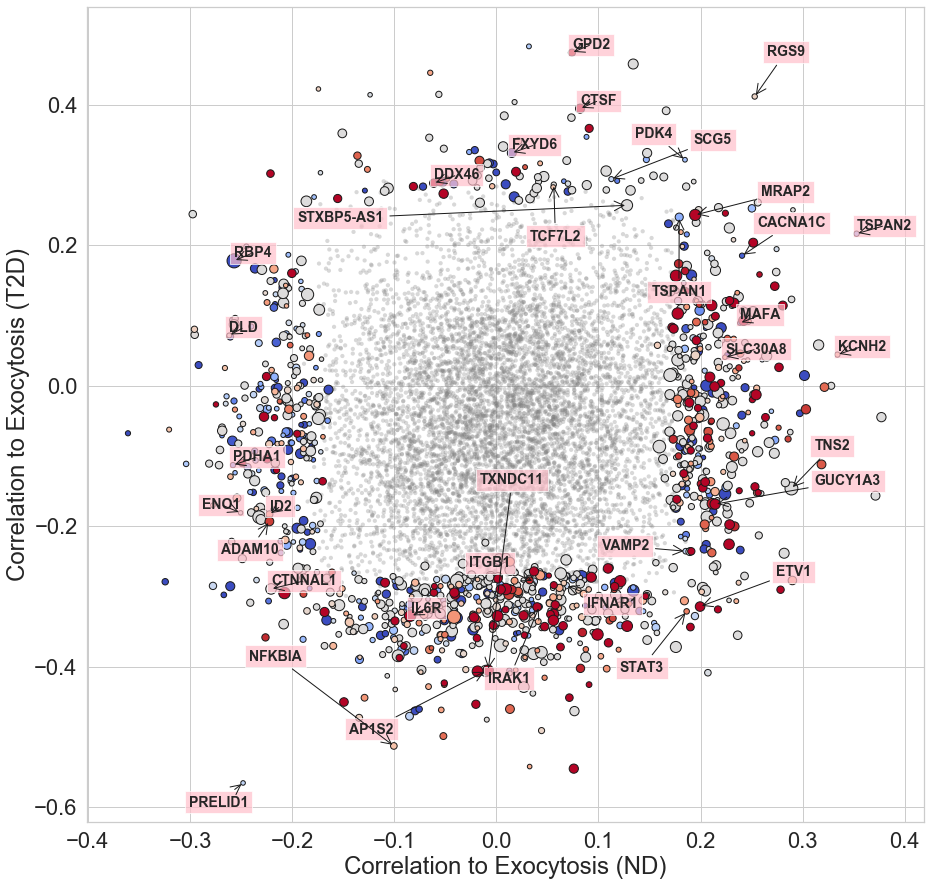

In [23]:

sns.set(font_scale=2)
sns.set_style('whitegrid')
fig,ax =plt.subplots(1,1,figsize=(15,15))
#make background plot
ax = sns.scatterplot(x="corr_raw_mean_ND", y="corr_raw_mean_T2D", data=merged_df,
           size=20,
             alpha=0.3, linewidth=0,color='gray',legend=False,ax=ax, rasterized=True)
conds = (np.abs(merged_df.zscore_ND) >2) | (np.abs(merged_df.zscore_T2D) >2)
conds = (np.abs(merged_df.zscore_raw_mean_ND) >2) | (np.abs(merged_df.zscore_raw_mean_T2D) >2)

merged_sig = merged_df[conds]

#make highlighted genes
ax = sns.scatterplot(x="corr_raw_mean_ND", 
                     y="corr_raw_mean_T2D", 
                     data=merged_sig,
                     hue='logFCmedian',
                     size='pct_ratio',
                     sizes=(20,200),
                     hue_norm=(-1,1), 
                     alpha=1.0, 
                     linewidth=1.0,
                     edgecolor='k',
                     palette='coolwarm',
                     ax=ax,
                     legend=False)

#'GPD2','EXT2','ETV1','RBP4','MAFA','MDK','CACNA1C']
#conds = (merged_df.corr_raw_mean_T2D>0.3) & (merged_df.logFCmedian>0)
#genes = merged_sig.reindex(TF_list_Fantom5['Symbol'],).dropna(axis=0,how='all').index.tolist()
genes =['ETV1','STAT3','NFKBIA','PRELID1','IL6R','IRAK1','ITGB1','IFNAR1','AP1S2']
genes.extend(['TCF7L2','GPD2','RGS9','PDK4','SCG5','FXYD6','CTSF','DDX46','STXBP5-AS1'])
genes.extend(['ENO1','ID2','RBP4','PDHA1','DLD','TXNDC11','ADAM10','CTNNAL1'])
genes.extend(['MAFA','MRAP2','GUCY1A3','TSPAN1','SLC30A8','CACNA1C','KCNH2','TSPAN2','TNS2','VAMP2'])
#genes = merged_df[conds].index.tolist()
df_labels = merged_df.loc[genes,['corr_raw_mean_ND','corr_raw_mean_T2D']]


ax.set_xlabel('Correlation to Exocytosis (ND)')
ax.set_ylabel('Correlation to Exocytosis (T2D)')
from adjustText import adjust_text

texts = []
#where k is the index (gene name) and v are the columns (correlation values for each axis to plot)
for  k, v in df_labels.iterrows():
    texts.append(plt.text(v[0], v[1], k, size=14,weight='bold',bbox=dict(facecolor='pink',alpha=0.7)))
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=1),
        expand_text=(1.5,2.1), expand_points=(1.01, 1.05),
        force_text=(1.5, 2.5), force_points=(1, 3))
fig.savefig(fig_folder +'fig5d.pdf')

In [24]:
#Identify genes that show downregulation in T2D and are within ND genes
merged_df[(merged_df.zscore_raw_mean_ND >2) &(merged_df.log2_FC <-1)].index.tolist()

['APCDD1L-AS1', 'NUP210', 'TNS2', 'FAM20B', 'PGAP2']

In [25]:
#Calculate bootstrap intervals for enrichhment of ND correlated genes
# 400 genes is equivalent to genes that show correlation/anticorrelation to exocytosis in ND donors
res_random = []
n_bootstrap = 10000
for i in np.arange(n_bootstrap):
    x = merged_df.sample(n= 400, replace=True)
    res_random.append(x['logFCmedian'].mean())

res_random = pd.DataFrame(res_random)

In [26]:
print('Quantile <5%: {}', res_random.quantile(0.05).values)
print('Quantile >95% {}', res_random.quantile(0.95).values)

Quantile <5%: {} [-0.08345459]
Quantile >95% {} [ 0.10061182]


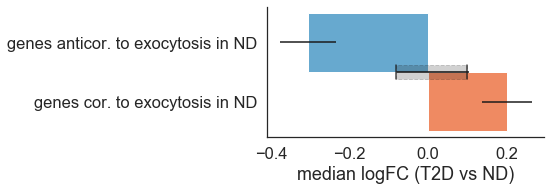

In [27]:
sns.set(font_scale=1.5)
sns.set_style('white')

#calculate change in T2D in genes that correlate to function on ND
x = [None] * 2
y = [None] * 2
cond1=(merged_df.zscore_raw_mean_ND >2) &((merged_df['pct cells_ND'] >0))
x[0] = merged_df[cond1]['logFCmedian'].mean()
y[0]= merged_df[cond1]['logFCmedian'].sem()

cond1=(merged_df.zscore_raw_mean_ND <-2) &((merged_df['pct cells_ND'] >0))
x[1] = merged_df[cond1]['logFCmedian'].mean()
y[1]= merged_df[cond1]['logFCmedian'].sem()

fig, ax = plt.subplots(1,1,figsize=(8,3))
colors = ['#ef8a62','#67a9cf']
plt.barh([0,1], x, 1, xerr=y,color=colors)

ci_range = [-0.08, 0.1]

plt.arrow(x=ci_range[0], y=0.5, dx=ci_range[1]-ci_range[0], dy=0, color='k', alpha=0.8, linestyle='-')
plt.axvline(x=ci_range[0], ymin=0.45, ymax=0.55, color='k', alpha=0.8, linestyle='-')
plt.axvline(x=ci_range[1], ymin=0.45, ymax=0.55, color='k',alpha=0.8,  linestyle='-')
plt.axvspan(xmin=ci_range[0], xmax=ci_range[1], ymin=0.45,ymax=0.55, color='k', alpha=0.2 ,linestyle='--')

ax.set_yticks([0,1])
ax.set_yticklabels(['genes cor. to exocytosis in ND', 'genes anticor. to exocytosis in ND'],rotation=0)
ax.set_xlabel('median logFC (T2D vs ND)')
fig.tight_layout()
sns.despine()
fig.savefig(fig_folder+'fig5c.pdf')

#### Pathway analysis

In [28]:
pathways = pd.read_csv(analysis_folder + 'correlations_betacell/beta_correlations_all/pathway_analysis.csv', sep=';')
pathways['logFDR'] = -np.log10(pathways['FDR q-value']) 
pathways_pval =pathways.pivot(index='Description',columns='Dataset',values='logFDR').fillna(0)
pathways_k =pathways.pivot(index='Description',columns='Dataset',values='k/K').fillna(0)
#make indexing for main pathway group
new_indexing = pd.DataFrame(pathways.drop_duplicates(subset='Description').set_index('Description')['MetaName'])#pathways_pval#pathways[['Description','MetaName']].index.map(payhways_pval)
#read tables of pathways and genes
pathways_genes = pd.read_csv(analysis_folder + 'correlations_betacell/beta_correlations_all/pathway_genes.csv', sep=';')
#make new incex for reactome
new_indexing_reactome = pd.DataFrame(pathways.drop_duplicates(subset='Description').set_index('Gene Set Name')[['MetaName']])

/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


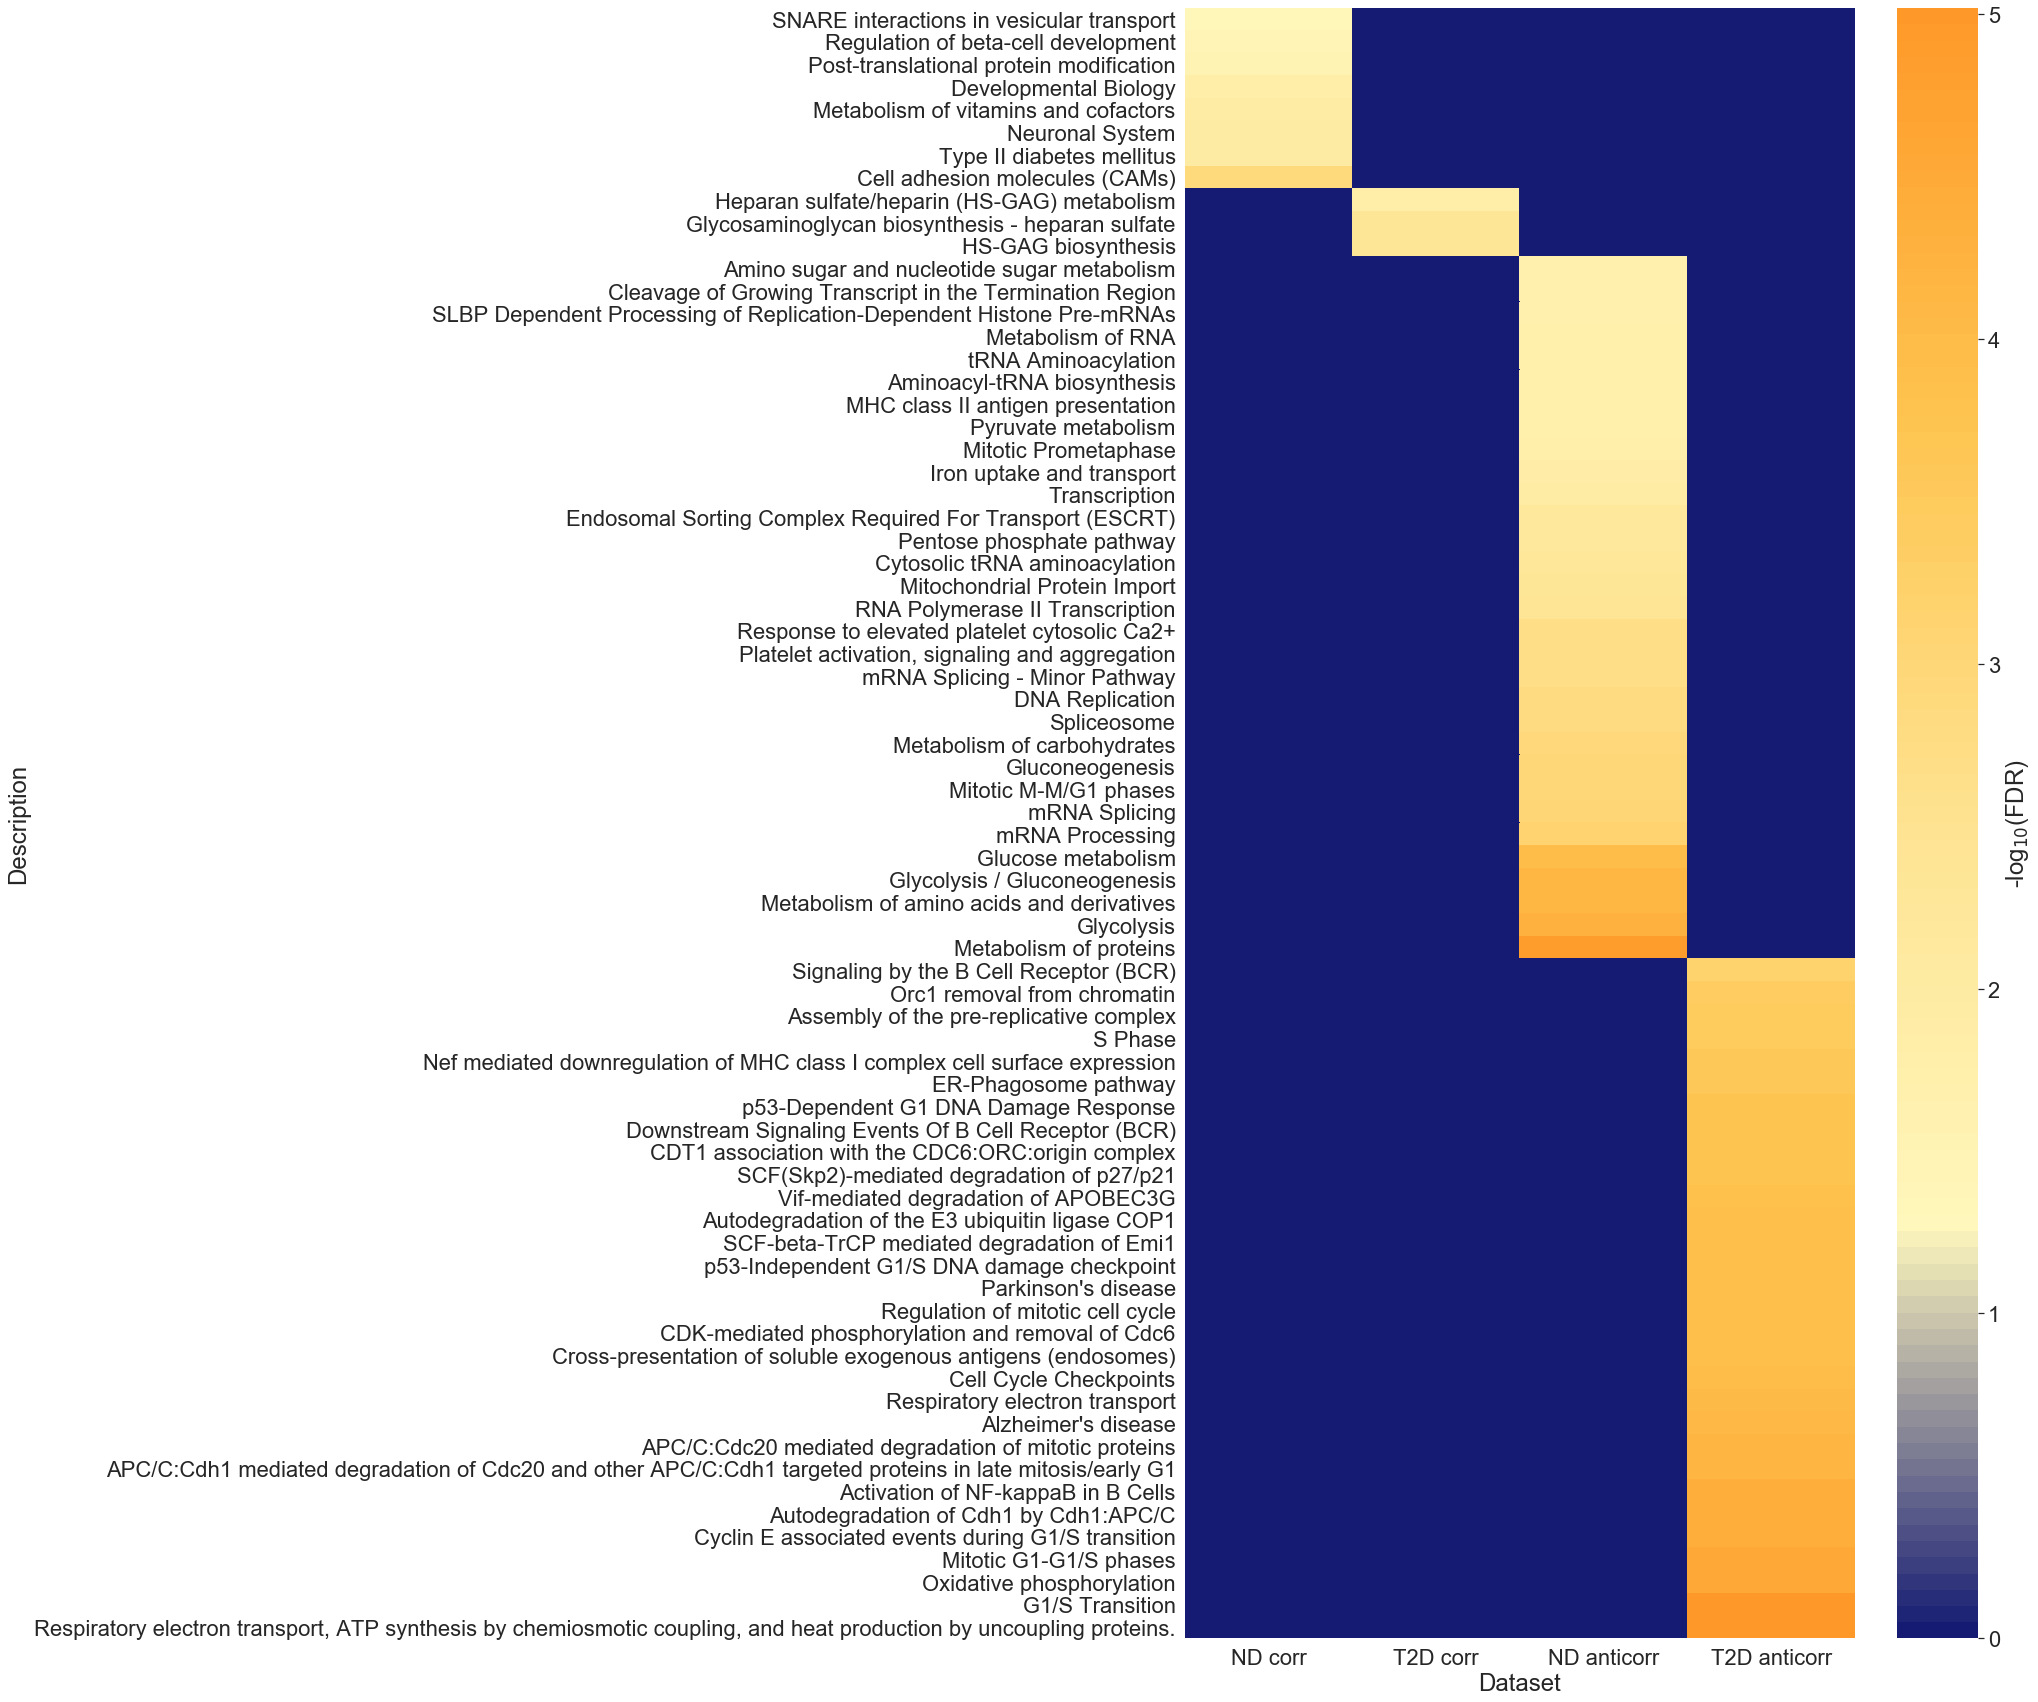

In [29]:
sns.set(font_scale=2)
path_sort_pval_unique = pathways_pval[pathways_pval[(pathways_pval>0)].count(axis=1) ==1]
colorls=['#151B73','#fff7bc','#fee391','#fec44f','#fe9929']
fig, ax = plt.subplots(1,1,figsize=(15,30))
path_sort_pval_unique = path_sort_pval_unique.sort_values(by=['T2D anticorr','ND anticorr','T2D corr','ND corr'])[['ND corr','T2D corr','ND anticorr','T2D anticorr']]
cmap = make_colormap_from_colorlist(list_colors=colorls)
sns.heatmap(path_sort_pval_unique,cmap=cmap, yticklabels=1,ax=ax,linewidths=0,cbar_kws={'label':'-log$_{10}$(FDR)'})
fig.tight_layout()
fig.savefig(fig_folder+ 'suppfig5c.pdf')

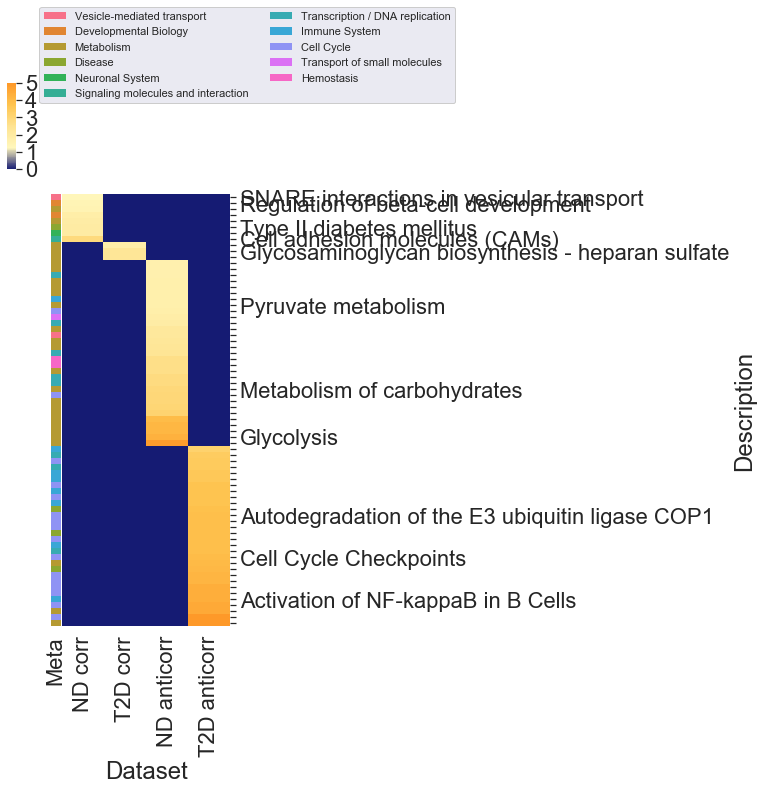

In [30]:

path_sort_pval_unique['Meta'] = new_indexing['MetaName']
path_sort_pval_unique = path_sort_pval_unique.replace({'Metabolism of proteins': 'Metabolism',
                               'Metabolism of RNA': 'Metabolism','Carbohydrate metabolism': 'Metabolism',
                                                      'Transcription': 'Transcription / DNA replication','DNA Replication': 'Transcription / DNA replication',
                                                      })
path_sort_pval_unique = path_sort_pval_unique.sort_values(by=['T2D anticorr','ND anticorr','T2D corr','ND corr','Meta'])[['ND corr','T2D corr','ND anticorr','T2D anticorr','Meta']]

genestokeep = ['SNARE interactions in vesicular transport','Regulation of beta-cell development','Cell adhesion molecules (CAMs)','Type II diabetes mellitus',
               'Glycosaminoglycan biosynthesis - heparan sulfate','Autodegradation of the E3 ubiquitin ligase COP1',
                'Pyruvate metabolism',
               'Activation of NF-kappaB in B Cells','Metabolism of carbohydrates','Glycolysis',
                'Cell Cycle Checkpoints','Antigen processing-Cross presentation','Regulation of Apoptosis']
#labels to kepp

r = path_sort_pval_unique.index.values.copy()
for i,gene in enumerate(r):
    if gene not in genestokeep:
        r[i] = ' '

#colors
val_col = path_sort_pval_unique['Meta'].unique()
lut = dict(zip(val_col, sns.color_palette('husl',len(val_col))))
row_colors = path_sort_pval_unique['Meta'].map(lut)
g = sns.clustermap(path_sort_pval_unique.drop('Meta',axis=1),cmap=cmap, 
                   row_colors=row_colors,col_cluster=False,row_cluster=False,yticklabels=r,figsize=(4,10))


sns.set(font_scale=1)

#### make legends ####
for key, color in lut.items():
    g.ax_col_dendrogram.bar(0, 0, color=lut[key],
                            label=key, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=2,frameon=True,fancybox=True,framealpha=1, bbox_to_anchor=(1.1,1.25))

g.savefig(fig_folder+ 'fig5e.pdf')

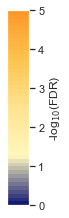

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(2, 3))
ax1 = fig.add_axes([0.1, 0.05, 0.15,0.9])
cmap = make_colormap_from_colorlist(list_colors=['#151B73',
     
'#fff7bc',
'#fee391',
'#fec44f',
        '#fe9929'],
                              bins=50)
norm = mpl.colors.Normalize(vmin=0, vmax=5)

import matplotlib.ticker as ticker
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('-log$_{10}$(FDR)')
fig.savefig(fig_folder + 'fig5e_cbar.pdf')

#### Supp Fig 5a

In [32]:
filter_condition = {'cell_type': ['beta'], 
                    'DiabetesStatus': ['healthy'],
               'Patched': ['Yes'],
                'Glucose_mM': [5,10],
                'TimefromDispersion_days': [1,2,3,4],
                          'preincubation': ['Yes','No']}
filtered_dataset = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)

s = filtered_dataset.copy()
s.samplesheet = s.samplesheet[s.samplesheet['Body mass index (BMI):'] > 30]
ts1 = s.copy()

s = filtered_dataset.copy()
s.samplesheet = s.samplesheet[(s.samplesheet['Body mass index (BMI):'] < 24)]
ts2 = s.copy()

In [33]:
len(ts1.samplesheet.DonorID.unique())

4

In [34]:
print('N cells group high BMI: {0}\n N donors group high BMI:\n{1},\n Cells per donor {2}'.format(
      ts1.counts.shape[1],  
    len(ts1.samplesheet.DonorID.unique()),
    ts1.samplesheet.DonorID.value_counts()))
print('N cells group low BMI: {0}\n N donors group low BMI:\n{1},\n Cells per donor {2}'.format(
      ts2.counts.shape[1],
    len(ts2.samplesheet.DonorID.unique()),
    ts2.samplesheet.DonorID.value_counts()))

N cells group high BMI: 30
 N donors group high BMI:
4,
 Cells per donor R234    10
R256     9
R264     8
R246     3
Name: DonorID, dtype: int64
N cells group low BMI: 39
 N donors group low BMI:
7,
 Cells per donor R233    13
R239    12
R237     6
R247     2
R232     2
R242     2
R229     2
Name: DonorID, dtype: int64


In [35]:
t = ts1.counts.median(axis=1) - ts2.counts.median(axis=1)
t = t.rename('medianlogFC_BMI')

In [36]:
#calculate logFC
logFC_t2dND = log_FC(ts1, ts2, logbase=2, pseudocount=1)
df = pd.concat([merged_df.drop('log2_FC',axis=1),t,logFC_t2dND],join='inner',axis=1)

In [37]:
#Calculate bootstrap intervals for enrichhment of ND correlated genes
# 400 genes is equivalent to genes that show correlation/anticorrelation to exocytosis in ND donors
res_random = []
n_bootstrap = 10000
for i in np.arange(n_bootstrap):
    x = df.sample(n= 400, replace=True)
    res_random.append(x['medianlogFC_BMI'].mean())

res_random = pd.DataFrame(res_random)

In [38]:
print('Quantile <5%: {}', res_random.quantile(0.05).values)
print('Quantile >95% {}', res_random.quantile(0.95).values)

Quantile <5%: {} [-0.08988657]
Quantile >95% {} [ 0.1577355]


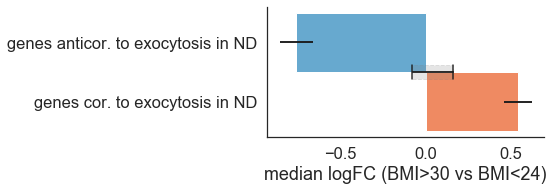

In [39]:
sns.set(font_scale=1.5)
sns.set_style('white')

#calculate change in T2D in genes that correlate to function on ND
x = [None] * 2
y = [None] * 2
cond1=(df.zscore_raw_mean_ND >2) & (df['pct cells_ND'] >0)
x[0] = df[cond1]['medianlogFC_BMI'].mean()
y[0]= df[cond1]['medianlogFC_BMI'].sem()

cond1=(df.zscore_raw_mean_ND <-2) & (df['pct cells_ND'] >0)
x[1] = df[cond1]['medianlogFC_BMI'].mean()
y[1]= df[cond1]['medianlogFC_BMI'].sem()

fig, ax = plt.subplots(1,1,figsize=(8,3))
colors = ['#ef8a62','#67a9cf']
plt.barh([0,1], x, 1, xerr=y,color=colors)


plt.barh([0,1], x, 1, xerr=y,color=colors)

ci_range = [-0.08, 0.16]

plt.arrow(x=ci_range[0], y=0.5, dx=ci_range[1]-ci_range[0], dy=0, color='k', alpha=0.9, linestyle='-')
plt.axvline(x=ci_range[0], ymin=0.45, ymax=0.55, color='k', alpha=0.9, linestyle='-')
plt.axvline(x=ci_range[1], ymin=0.45, ymax=0.55, color='k', alpha=0.9, linestyle='-')
plt.axvspan(xmin=ci_range[0], xmax=ci_range[1], ymin=0.45,ymax=0.55, color='gray', alpha=0.2 ,linestyle='--')

    
ax.set_yticks([0,1])

ax.set_yticklabels(['genes cor. to exocytosis in ND', 'genes anticor. to exocytosis in ND'],rotation=0)
ax.set_xlabel('median logFC (BMI>30 vs BMI<24)')
fig.tight_layout()
sns.despine()
fig.savefig(fig_folder+'suppfig_5B.pdf')

### ETV1 specific plots (patch-seq and Sandberg)

Patch-seq data

/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/pandas/core/reshape/reshape.py:731: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  frame = frame.loc[:, id_vars + value_vars]
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


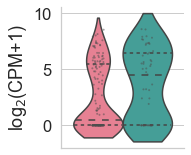

In [40]:
filter_condition = {'cell_type': ['beta'], 
                    'DiabetesStatus': ['healthy','T2D'],
                   'Patched': ['Yes'],#,
                   'TimefromDispersion_days': [1,2,3,4],
                   'Glucose_mM': [5,10]}#,

filtered_dataset = filter_samplesheet(ds_pclamp, filter_dict= filter_condition)
ts = filtered_dataset

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

groupby_col = 'DiabetesStatus'
groups = ['healthy','T2D']
thres=2
filtered_dataset = ts.copy()
genes = [ 'ETV1']
n_par = len(genes)
n_size = 3 * n_par
fig,axs= plt.subplots(nrows=1, ncols=1, figsize=(n_size,2.5))

filter_cols = [groupby_col]
plot_test = ts.samplesheet.loc[:, filter_cols].copy()
plot_testb = ts.counts.loc[genes,:].T.copy()
plot_test = pd.concat([plot_test,plot_testb],axis=1)

data = plot_test.melt(id_vars=['cell_type',groupby_col], value_vars=genes, var_name='gene',value_name='log2(CPM)')

axs = sns.violinplot(x='gene', y='log2(CPM)', data=data, hue=groupby_col, 
                        ax=axs, cut=1, linewidth=1.5, palette='husl',alpha=1,inner='quartile',scale='width')
axs = sns.stripplot(x='gene', y='log2(CPM)', data=data, hue=groupby_col, jitter=True, alpha=0.5, dodge=True, ax=axs,palette=['0.3','0.3','0.3','0.3'],s=2)
axs.set_yticks([0,5,10])

axs.set_ylabel(r'log$_2$(CPM+1)')
axs.set_xlabel('')
axs.set_xlabel('')
axs.xaxis.set_visible(False)
axs.legend().set_visible(False)

sns.despine()
fig.tight_layout()
fig.savefig(fig_folder+'Fig_5F.pdf')

In [41]:
res = df_get_mu_pvals(plot_test, genes, column_class='DiabetesStatus',categories=['healthy','T2D'])
res

,pval,FDR
ETV1,0.008753,0.008753


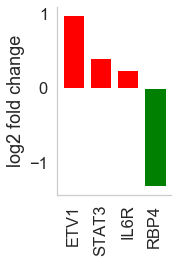

In [42]:
ds_plot = filtered_dataset
groupby_col = 'DiabetesStatus'
groups = ['healthy','T2D']
genelist = ['ETV1','STAT3','IL6R','RBP4']
group1 = filter_samplesheet(ds_plot, filter_dict= {groupby_col :[ groups[0]]})
group2 = filter_samplesheet(ds_plot, filter_dict= {groupby_col :[groups[1]]})
log_FC_res = log_FC(group1, group2, logbase=2, pseudocount=1)
log_FC_res =log_FC_res[genelist]

s_p = pd.DataFrame(-log_FC_res, columns=['log2_FC'])
s_p['color'] ='green'
s_p.loc[s_p['log2_FC']>0,'color'] = 'red'
data =s_p['log2_FC'].fillna(0)
cdata=s_p['color']

fig,ax =plt.subplots(1,1,figsize=(3,4))
ind = np.arange(data.shape[0])
ax.bar(ind, data.values, color=cdata.values)
ax.set_xticks(ind)
ax.set_xticklabels(data.index,rotation=90)
ax.set_ylabel('log2 fold change')
ax.grid(False)
plt.tight_layout()
sns.despine()
fig.savefig(fig_folder+'Fig_5F_logFC.pdf')

Segerstolpe dataset

In [43]:
#### Load and reformat Segestolpe dataset
data_sand= pd.read_csv(root_folder+ 'Sandberg_pancreas_refseq_rpkms_counts_3514sc.txt', 
                   sep='\t',skiprows=1,header=None)
col_names = pd.read_csv(root_folder+'Sandberg_header.txt', 
                   sep='\t')
col_names = col_names.columns.drop('Unnamed: 0')
data_sand =data_sand.set_index(0).iloc[:,3515:7030]
data_sand.columns = col_names
data_sand = data_sand.iloc[0:26178,:]
mdata_sand = pd.read_csv(root_folder+'Sandberg_E-MTAB-5061.sdrf.txt', sep='\t')

mdata_sand = mdata_sand.set_index('Source Name')
dict_rename = {'Characteristics[body mass index]':'BMI',
 'Characteristics[individual]':'DonorID',
'Characteristics[cell type]':'cell_type', 'Characteristics[disease]':'DiabetesStatus',
       'Characteristics[sex]':'Sex', 'Characteristics[age]':'Age'}
mdata_sand.rename(columns=dict_rename, inplace=True)
mdata_sand['DiabetesStatus'].replace({'normal':'healthy', 'type II diabetes mellitus':'T2D'}, inplace=True)
mdata_sand['DiabetesStatus'].replace({'male':'M', 'female':'F'}, inplace=True)

mdata_sand.cell_type.replace({'delta cell':'delta', 
                              'alpha cell':'alpha', 
                              'gamma cell':'gamma',
                              'ductal cell':'ductal',
                              'acinar cell':'acinar',
                              'beta cell':'beta',
                              'unclassified endocrine cell': 'unclassified endocrine', 
                              'co-expression cell':'co-expression',
                              'MHC class II cell':'MHC class II', 'PSC cell':'PSC', 
                              'endothelial cell':'endothelial',
                              'epsilon cell':'epsilon', 
                              'unclassified cell':'unclassified'}, inplace=True)

mdata_sand.DonorID.replace({'HP1504101T2D':'T2D1', 
                            'HP1508501T2D':'T2D2', 
                            'HP1525301T2D':'T2D3', 
                            'HP1526901T2D':'T2D4',
                            'AZ':'H1', 
                            'HP1502401':'H2', 
                            'HP1504901':'H6', 
                            'HP1506401':'H3', 
                            'HP1507101':'H4',
       'HP1509101':'H5'},inplace=True)
ds_sand = Dataset(counts_table=CountsTable(data_sand),samplesheet=SampleSheet(mdata_sand))

norm = ds_sand.counts.sum(axis=0)
ds_sand.counts = 1e6 * ds_sand.counts / norm
ds_sand.counts.pseudocount = 1
ds_sand.counts = ds_sand.counts.log(base=2)
ds_sand.counts.pseudocount = 1

ds_sand.samplesheet['n_genes_1'] = (ds_sand.counts > 1).sum(axis=0)
ds_sand.samplesheet['n_genes_3'] = (ds_sand.counts > 3).sum(axis=0)

/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/pandas/core/reshape/reshape.py:731: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  frame = frame.loc[:, id_vars + value_vars]
/Users/joan/anaconda/envs/scanpy/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


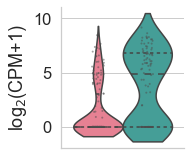

In [44]:
filter_condition = {'cell_type': ['beta'], 
                    'DiabetesStatus': ['healthy','T2D']}#,

filtered_dataset = filter_samplesheet(ds_sand, filter_dict= filter_condition)
ts = filtered_dataset

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

groupby_col = 'DiabetesStatus'
groups = ['healthy','T2D']
thres=2
filtered_dataset = ts.copy()
genes = [ 'ETV1']
n_par = len(genes)
n_size = 3 * n_par
fig,axs= plt.subplots(nrows=1, ncols=1, figsize=(n_size,2.5))

filter_cols = [groupby_col]
plot_test = ts.samplesheet.loc[:, filter_cols].copy()
plot_testb = ts.counts.loc[genes,:].T.copy()
plot_test = pd.concat([plot_test,plot_testb],axis=1)

data = plot_test.melt(id_vars=['cell_type',groupby_col], value_vars=genes, var_name='gene',value_name='log2(CPM)')

axs = sns.violinplot(x='gene', y='log2(CPM)', data=data, hue=groupby_col, 
                        ax=axs, cut=1, linewidth=1.5, palette='husl',alpha=1,inner='quartile',scale='width')
axs = sns.stripplot(x='gene', y='log2(CPM)', data=data, hue=groupby_col, jitter=True, alpha=0.5, dodge=True, ax=axs,palette=['0.3','0.3','0.3','0.3'],s=2)
axs.set_yticks([0,5,10])

axs.set_ylabel(r'log$_2$(CPM+1)')
axs.set_xlabel('')
axs.set_xlabel('')
axs.xaxis.set_visible(False)
axs.legend().set_visible(False)

sns.despine()
fig.tight_layout()
fig.savefig(fig_folder+'suppfig_4D.pdf')

In [45]:
res = df_get_mu_pvals(plot_test, genes, column_class='DiabetesStatus',categories=['healthy','T2D'])
res

,pval,FDR
ETV1,1.034358e-09,1.034358e-09


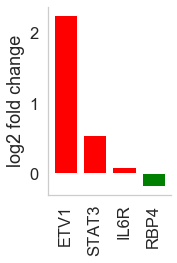

In [46]:
ds_plot = filtered_dataset
groupby_col = 'DiabetesStatus'
groups = ['healthy','T2D']
genelist = ['ETV1','STAT3','IL6R','RBP4']
group1 = filter_samplesheet(ds_plot, filter_dict= {groupby_col :[ groups[0]]})
group2 = filter_samplesheet(ds_plot, filter_dict= {groupby_col :[groups[1]]})
log_FC_res = log_FC(group1, group2, logbase=2, pseudocount=1)
log_FC_res =log_FC_res[genelist]

s_p = pd.DataFrame(-log_FC_res, columns=['log2_FC'])
s_p['color'] ='green'
s_p.loc[s_p['log2_FC']>0,'color'] = 'red'
data =s_p['log2_FC'].fillna(0)
cdata=s_p['color']

fig,ax =plt.subplots(1,1,figsize=(3,4))
ind = np.arange(data.shape[0])
ax.bar(ind, data.values, color=cdata.values)
ax.set_xticks(ind)
ax.set_xticklabels(data.index,rotation=90)
ax.set_ylabel('log2 fold change')
ax.grid(False)
plt.tight_layout()
sns.despine()
fig.savefig(fig_folder+'suppfig_4D_logFC.pdf')